# Data Preparation

In [65]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
from logistic import LogisticRegression, GradientDescentOptimizer

# generate random data points
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Gradient Descent Experimentation

First lets performa a vanilla gradient descent with pdims = 2, a small α, and 𝛽 = 0. We would expect the loss to decrease monotonically. 

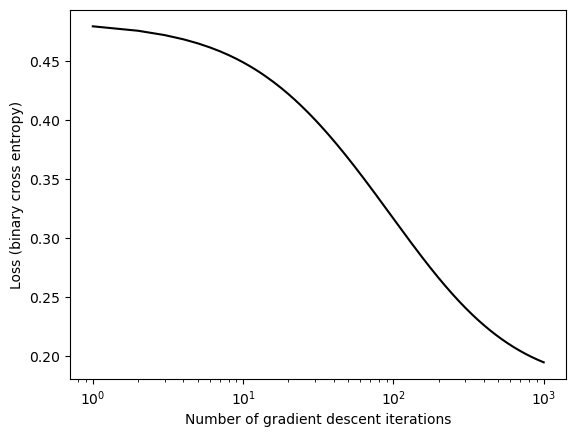

In [66]:
# instantiate a model and an optimizer
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# for keeping track of loss values
loss_vec = []

for _ in range(1000):

    # not part of the update: just for tracking our progress    
    loss = LR.loss(X, y) 
    loss_vec.append(loss)

    # only this line actually changes the parameter value
    opt.step(X, y, alpha = 0.1, Beta = 0)

plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")
plt.semilogx()
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

The implementation appears correct because the loss function decreases monotonically over iterations, which is expected in properly functioning gradient descent for logistic regression. The smooth decline in binary cross-entropy loss indicates that the model is learning effectively without divergence or oscillations. Additionally, the logarithmic x-axis confirms that the loss reduction is well-behaved over multiple orders of magnitude in iterations. These characteristics suggest that the weight updates are correctly applied and that the optimization process is progressing as intended. Now on the same data, implement gradient descent with a 𝛽 = .9 and compare the difference in plots.

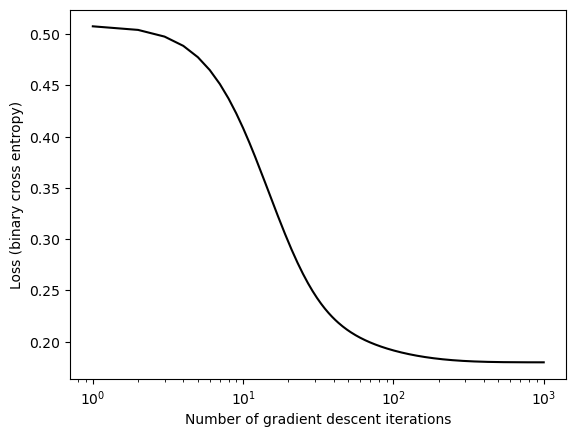

In [67]:
# instantiate a model and an optimizer
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# for keeping track of loss values
loss_vec = []

for _ in range(1000):

    # not part of the update: just for tracking our progress    
    loss = LR.loss(X, y) 
    loss_vec.append(loss)

    # only this line actually changes the parameter value
    opt.step(X, y, alpha = 0.1, Beta = .9)

plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")
plt.semilogx()
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

Comparing the gradient descent with momentum (𝛽>0) to the previous vanilla gradient descent (𝛽=0), we observe that the addition of momentum leads to a smoother and faster convergence. The loss decreases more rapidly in the early iterations, demonstrating how momentum helps accelerate learning by reducing oscillations and maintaining directional consistency. In contrast, the previous descent without momentum had a more gradual decline in loss. This confirms that momentum improves optimization efficiency, reaching a lower loss in fewer iterations while maintaining stability. Now, let's explore how the algorithim handles overfitting where pdims > n_points.

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# generate random data points with pdims > n_points
def classification_data2(n_points = 150, noise = 0.2, p_dims = 300):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

# generate a training and test set with pdims > n_points
X_train, y_train = classification_data2(noise = 0.5)
X_test, y_test = classification_data2(noise = .5)

LR = LogisticRegression(max_iter = 1000)
m = LR.fit(X_train, y_train)

print("The model has a training accuracy of: " + str(LR.score(X_train, y_train)))

y_pred = LR.predict(X_test)
acc = accuracy_score(y_pred, y_test)

print("The model has a testing accuracy of: " + str(acc))

The model has a training accuracy of: 1.0
The model has a testing accuracy of: 1.0


Learning on real world data. The Breast Cancer Wisconsin (Diagnostic) dataset consists of 569 instances with 30 features, including measurements such as radius, texture, perimeter, and area, derived from cell nuclei in digitized breast mass images. The target is binary: diagnosing malignant (M) or benign (B) tumors. For more details and to cite the dataset, refer to the original paper: Wolberg, W., Mangasarian, O., Street, N., & Street, W. (1993). Breast Cancer Wisconsin (Diagnostic).

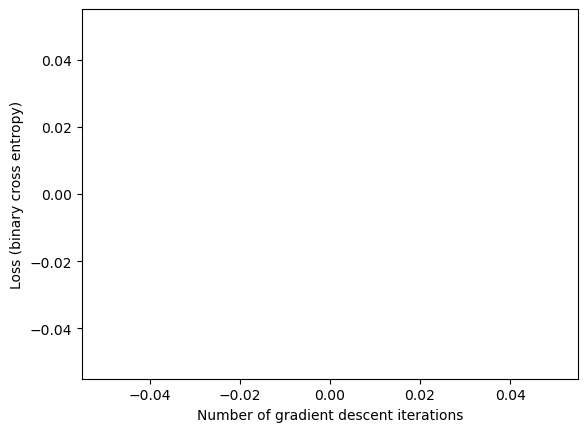

In [ ]:
from logistic import LogisticRegression, GradientDescentOptimizer
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
import numpy as np
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

X = X.to_numpy()
y = y.to_numpy()

X = torch.tensor(X, dtype = torch.float32)

y = np.where(y == 'M', 1, 0)  # Convert 'M' to 1 and 'B' to 0
y = torch.tensor(y, dtype = torch.float32)

# perform a train test split into 60% training data and 40% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4)

y_train = y_train.squeeze()  # Converts (341, 1) to (341,)

# perform a logistic regression on the data
# instantiate a model and an optimizer
LR1 = LogisticRegression()
LR2 = LogisticRegression() 
opt1 = GradientDescentOptimizer(LR1)
opt2 = GradientDescentOptimizer(LR2)

# for keeping track of loss values
loss1_vec = []
loss2_vec = []

for _ in range(1000):

    # not part of the update: just for tracking our progress    
    loss1 = LR1.loss(X_train, y_train) 
    loss2 = LR2.loss(X_train, y_train)
    loss1_vec.append(loss1)
    loss2_vec.append(loss2)

    # only this line actually changes the parameter value
    opt1.step(X_train, y_train, alpha = 0.01, Beta = 0)
    opt2.step(X_train, y_train, alpha = 0.01, Beta = .9)


plt.plot(torch.arange(1, len(loss1_vec) + 1), loss1_vec, color="blue")
plt.plot(torch.arange(1, len(loss2_vec) + 1), loss2_vec, color="red")
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")